In [ ]:
import marimo as mo
import seaborn as sns
import logging
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

logging.disable(logging.CRITICAL) # bmotif has many logs we don't need for this notebook

We need a way of estimating the cost savings of adopting semantic metadata like Brick or 223P. This notebook is an attempt to develop a simple cost model which we can iterate and improve upon. We will focus on the *time* it takes to perform each of these tasks on a per-point or per-building basis, and use those time estimates in conjunction with hourly rates to estimate costs.

Here are the initial elements and parameters of the time/cost parts of the model:

| Element              | Symbol      | Description                                                                                                | Units                     | Example                  |
|----------------------|-------------|------------------------------------------------------------------------------------------------------------|---------------------------|--------------------------|
| Tagging Points       | $T_{tag}$   | Time to tag/label a point in the Building Management System (BMS) or other software.                       | time/point                | `30 seconds per point`   |
| Building a Model     | $T_{build}$ | Time to build the metadata model of the building (can include or exclude the time to tag the points).        | time/building             |                          |
| Checking Points      | $T_{check}$ | Time to check that points exist and are tagged correctly for a given Fault Detection and Diagnostics (FDD) rule. | time/point                |                          |
| Fixing Points        | $T_{fix}$   | Time to fix a point label/tag due to spelling errors, missing tags, extra tags, etc.                       | time/point                |                          |
| Finding Rules        | $T_{find}$  | Time it takes to choose an appropriate fault detection rule for a given class of equipment.  *not sure how to use this, or what reasonable values would be*                 | time/equipment            |                          |
| Application Config.  | $T_{config}$| Time to configure an application *after* all the points have been identified and fixed.                    | time/application          |                          |
| Billable Hourly Rate          | $C_{rate}$  | The *billable* cost per hour of the technician, individual, or team performing the work.                              | cost/time                 | e.g., `$/hour`           |

*Having all of these parameters does mean that we need to estimate or source numbers for each of them, which might impact the accuracy of the model. These parameters also assume that building commissioning is carried out in a particular way. Certain platform features, e.g. PISoft templates, can help save time over other platforms. Generic "$/point" reference numbers may be a better approach.*

In [ ]:
## Some draft constants for the parameters above

# ranges of values of T_tag, in seconds
T_tag = [
    5, 10, 30
]

#ranges of values of T_build, in seconds (1hr, 2hr)
T_build = [
    3600, 7200
]

T_check = [
    5, 10, 30
]

# if 10% errors, and it takes 5 minutes to fix a tag, then
# avg cost is 30 seconds
T_fix = [
    30
]

# 1, 2 minutes to configure an app after all the points are done
T_config = [
    60, 120
]

# the combination of all possible sums of T_tag, T_check, T_fix
T_point = [
    sum([tt, tc, tf]) for tt, tc, tf in product(T_tag, T_check, T_fix)
]

# billable rate in $USD / hr
# $50/hr is GS13 salary; billable is probably ~$200/hr
# $250/hr is "System Specialist on Straight time, no service contract rate"
#  from a recent rate sheet (2024) for EnviroNet Systems 
C_rate = [
    200, 250
]
# we will also add 30% for overhead + profit margin

The other elements of the cost model depend on the specific building and application suite. These are:

| Parameter             | Symbol             | Description                                                                      |
|-----------------------|--------------------|----------------------------------------------------------------------------------|
| Set of applications   | $A$                | The set of all possible rules that would run on the building (used implicitly) |
| Applications per equipment | $A_{c}$      | The number of applications (e.g. FDD rules) for a given equipment class $c$  |
| Points for an application | $P_{c,i}$      | Number of distinct points required for application $i$ on equipment class $c$    |
| Instances of equipment | $N_{c}$      | The number of instances of a given equipment class $c$ in the building         |
| Equipment Classes     | $C$                | The set of all unique equipment classes in the building (e.g., AHU, VAV, Chiller) |
| Number of Equip Classes| $N_C$             | The total number of unique equipment classes, i.e., $\|C\|$ |

$T_{build} + \sum_{c \in C} \left( N_c \cdot \sum_{i=1}^{A_c} \left( P_{c,i} T_{point} + T_{config} \right) \right)$

This is the total *labor* time spent setting up all applications on all equipment instances in the building:

- $T_{build}$ is the base cost to create the model w/o all the points (includes equipment, topology, etc)
- The outer sum $\sum_{c \in C}$ iterates over each unique equipment class in the building (e.g., AHU, VAV, Chiller).
- $N_c$ is the number of instances of a given equipment class $c$.
- The inner sum $\sum_{i=1}^{A_c}$ iterates over all $A_c$ applications configured for each instance of equipment class $c$. $A_c$ is the number of applications for equipment class $c$:
    - **$P_{c,i} \cdot T_{point}$**: This part calculates the time spent on point-related activities for a single application $i$ on one instance of equipment class $c$.
    - $P_{c,i}$ is the number of distinct points required for application $i$ on an instance of equipment class $c$.
    - $T_{point}$ is the avg time it takes to tag, fix, validate each point. You can break this down further, if you want:
        - $T_{tag}$ is the time to tag or ensure correct tagging for a single point for the specific needs of application $i$.
        - $T_{check}$ is the time to check a single point for correctness for application $i$.
        - $T_{fix}$ is the time allocated to fix a single point. (See assumptions below for interpretation).
        - The sum $(T_{tag} + T_{check} + T_{fix})$ gives the total time per point for these activities
    - Multiplying $T_{point} \cdot P_{c,i}$ gives the total point-related time for this application
    - Units: `points` $\cdot$ (`time/point` + `time/point` + `time/point`) = `time`.
- **$T_{config}$**: This is the time to configure application $i$ on one equipment instance *after* its points have been prepared:
    - Corresponds to the parameter $T_{config}$ (Application Configuration time).
    - Units: `time/application`.

### A note on `$/point` estimations

Ideally we get some real data in here.
Some reports like https://docs.nrel.gov/docs/fy22osti/82117.pdf use an average "cost per point". This can capture equip + labor (table A-1) or just equipment (table A-2). We are not interested in the capital expenses here. The value proposition of metadata is to reduce the labor costs by automating configuration and discovery of points (among other metadata). **TODO: need to find a way of estimating the *labor-only* per-point cost.**

### Assumptions in the Labor Cost Model

1.  **Scope of $T_{build}$**: We assume $T_{build}$ primarily covers the creation of the building's structural metadata model (e.g., system-zone relationships, equipment hierarchy) and does *not* include the tagging of the individual points (this is in $T_{tag}$)
2.  **Application-Specific Point Work ($T_{tag}$)**: The time $T_{tag}$ is assumed to be incurred for all $P_{c,i}$ points required by each application $i$ on each equipment instance of class $c$. This covers the effort to ensure each point has the specific tags or metadata attributes required by that particular application, which might involve adding new tags, refining existing ones, or verifying them against the application's requirements.
3.  **Interpretation of $T_{fix}$**: The parameter $T_{fix}$ (Time to fix a point) is applied to all $P_{c,i}$ points for each application. This interpretation implies that $T_{fix}$ is an *average time* spent on fixing-related activities per point considered for an application. This effectively bundles the probability of a point needing a fix and the actual time to perform a fix into a single average value applied to all points being processed for an application. For example, if 10% of points typically require a fix, and a fix takes 10 minutes, the average $T_{fix}$ per point would be 1 minute.
4.  **Rule Finding ($T_{find}$)**: $T_{find}$ is the time to select rules for an entire equipment *class*. This effort is performed once for each unique equipment class in $C$.
5.  **Homogeneity of Instances**: It's assumed that all $N_c$ instances of a given equipment class $c$ run the same $A_c$ applications, and each application $i$ requires the same number of points $P_{c,i}$ on any instance of that class.

In [ ]:
# now let's try an example with a real building and set of FDD rules
rules_file = 'rules/5.16.14.8-vav-ahu-fault.json' # from the relevant section of G36
model_file = 'bldg30.ttl'

from applicationsuite import ApplicationSuite
suite = ApplicationSuite(rules_file, model_file)

/Users/gabe/src/NREL/InteropMetadataApplications/metadata-cost-estimation/transform.py:192: UserWarning: Code: Differential_Temperature_Setpoint is not defined in namespace BRICK
  return string_to_shape(shapename, shape_graph, varname, value)


In [ ]:
df = suite.compute_labor_time_df(T_build, T_point, T_config, C_rate)
df

,C_rate,T_build,T_perpoint,time,cost
0,200,3600,40,6740,486.777778
1,250,3600,40,6740,608.472222
2,200,3600,40,7400,534.444444
3,250,3600,40,7400,668.055556
4,200,3600,45,7050,509.166667
...,...,...,...,...,...
67,250,7200,70,12860,1160.972222
68,200,7200,90,13440,970.666667
69,250,7200,90,13440,1213.333333
70,200,7200,90,14100,1018.333333


In [ ]:
# lets only look at a few of the attributes
subset = df[['T_perpoint', 'time', 'cost', 'C_rate']].drop_duplicates()
subset

,T_perpoint,time,cost,C_rate
0,40,6740,486.777778,200
1,40,6740,608.472222,250
2,40,7400,534.444444,200
3,40,7400,668.055556,250
4,45,7050,509.166667,200
...,...,...,...,...
59,70,12860,1160.972222,250
68,90,13440,970.666667,200
69,90,13440,1213.333333,250
70,90,14100,1018.333333,200


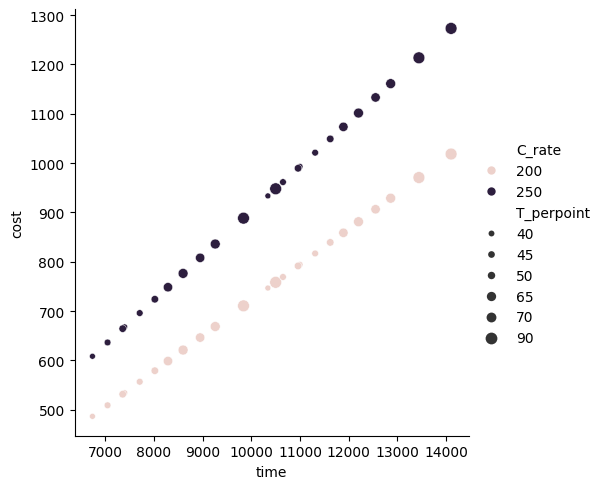

In [ ]:
sns.relplot(data=subset, x='time', y='cost', hue='C_rate', size='T_perpoint')
# 'time' is seconds
# 'cost' is $ USD

In [ ]:
# now we can compare with some of the published $/point numbers

# the base "$ cost per point". For comparison. See below.
C_point = [
    # from https://www.osti.gov/biblio/1880546
    541, # avg $/alarm I/O, table A-1
    1165, # avg $/sensor, table A-1 (RSmeans, includes equipment cost + labor)
]

In [ ]:
pdf = suite.compute_point_cost_df(C_point)
pdf

,C_point,cost
0,541,33542
1,1165,72230


In [ ]:
# where do these costs fall with respect to the others?
costs = pd.concat([df['cost'], pdf['cost']])
costs.describe().T

,cost
count,74.000000
mean,2228.587838
std,9085.541332
min,486.777778
25%,668.236111
50%,812.409722
75%,968.364583
max,72230.000000


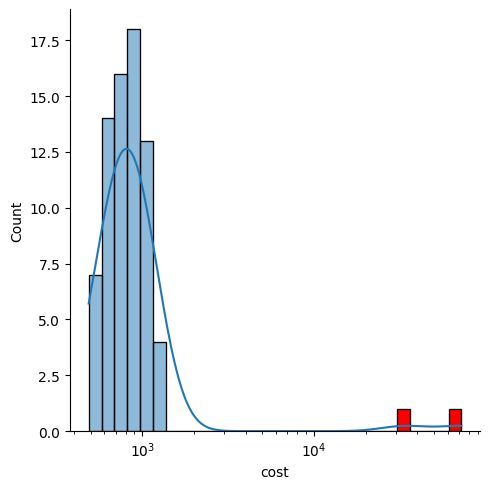

In [ ]:
# the two $/point estimates are *way* higher!

g = sns.displot(costs, log_scale=True, kde=True)
threshold = min(pdf['cost'])
for ax in g.axes.flat:
    for bar in ax.patches:  # ax.patches contains all the bar objects
        # Check if the bar is greater than the threshold
        if bar.get_x() + bar.get_width() > threshold:
            bar.set_facecolor('red')  # Color bars above the threshold in red
g